<a href="https://colab.research.google.com/github/haosulab/SAPIEN-tutorial/blob/master/3_physics.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Some core features of SAPIEN are not available on Colab, including the interactive viewer and ray-tracing functionalities. You need to run SAPIEN locally for full features. A more comprehensive tutorial including features that are only available to local environment can be found at [SAPIEN's documentation](https://sapien.ucsd.edu/docs/2.2/index.html).

# Tutorial 3: Physics

Since SAPIEN is a physical simulation framework, we would like to showcase how to change physical properties which lead to different behaviors.

In this tutorial, you will learn the following:

- Use `SceneConfig` to initialize default physical properties
- Use `PhysicalMaterial` to set different physical materials
- Create kinematic actors
- Enable damping for actors
- Get kinematic quantities (pose, velocity, angular velocity) of an actor

The example illustrates an object sliding down the slope. You can run the script with different arguments.

In [21]:
# Hyperparameters
obj = 'box' # The type of object. Choices are 'box' and 'sphere'
gravity = -9.8 # Z-axis gravity
angle = 30.0 # The angle of the slope
offset = 0.1 # Z-offset of the slope above the ground
static_friction = 0.3 # Static friction
dynamic_friction = 0.3 # Dynamic Friction
restitution = 0.1 # Restitution (elasticity of collision)
linear_damping = 0.0 # Linear damping (resistance proportional to linear velocity)
angular_damping = 0.0 # Angular damping (resistance proportional to angular velocity)


## Preparation

**Note: you need GPU runtime to run the notebook.**

In [30]:
%pip install sapien matplotlib
import sapien.core as sapien
import numpy as np
from PIL import Image
from  transforms3d.quaternions import axangle2quat

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Set default physical properties

Default physical properties can be specified when a scene is created. Those properties include gravity, static and dynamic friction, as well as [restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution) (elasticity of collision).

In [23]:
engine = sapien.Engine()
renderer = sapien.SapienRenderer()
engine.set_renderer(renderer)

scene_config = sapien.SceneConfig()
# The default physical properties can be modified through sapien.SceneConfig
print(scene_config.gravity)
print(scene_config.default_static_friction)
print(scene_config.default_dynamic_friction)
print(scene_config.default_restitution)
scene_config.gravity = np.array([0.0, 0.0, gravity])
scene = engine.create_scene(scene_config)
scene.set_timestep(1 / 100.0)

[ 0.    0.   -9.81]
0.30000001192092896
0.30000001192092896
0.10000000149011612


[2023-02-05 14:01:56.186] [SAPIEN] [warning] A second engine will share the same internal structures with the first one. Arguments passed to constructor will be ignored.
[2023-02-05 14:01:56.186] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2023-02-05 14:01:56.186] [SAPIEN] [warning] Setting renderer more than once should be avoided.


`SceneConfig` describes default physical properties, and can be passed to `Scene`.

## Set physical materials

`PhysicalMaterial` describes physical (contact) properties (friction and restitution) of the material of an actor. It can be specified when an actor is created. If not provided, the default physical material, induced by the scene’s default physical properties, will be used. Note that `PhysicalMaterial` can only be created by `create_physical_material(...)`.

In [24]:
physical_material: sapien.PhysicalMaterial = scene.create_physical_material(
    static_friction=static_friction,
    dynamic_friction=dynamic_friction,
    restitution=restitution,
)

Some other physical properties, like density, are directly provided to collision shapes. 

In [25]:
def create_sphere(
        scene: sapien.Scene,
        pose: sapien.Pose,
        radius,
        color=None,
        density=1000.0,
        physical_material: sapien.PhysicalMaterial = None,
        name='',
) -> sapien.Actor:
    """Create a sphere."""
    builder = scene.create_actor_builder()
    builder.add_sphere_collision(radius=radius, material=physical_material, density=density)
    builder.add_sphere_visual(radius=radius, color=color)
    sphere = builder.build(name=name)
    sphere.set_pose(pose)
    return sphere

> Note: The rolling resistance (friction) is not modeled in SAPIEN currently.

## Create a kinematic actor

Now, let’s create a slope. The slope should be a **kinematic** object, rather than a **dynamic** object. In other words, it can not be affected by external forces. We can set `is_kinematic=True` when building the actor.

In [26]:
def create_box(
        scene: sapien.Scene,
        pose: sapien.Pose,
        half_size,
        color=None,
        is_kinematic=False,
        density=1000.0,
        physical_material: sapien.PhysicalMaterial = None,
        name='',
) -> sapien.Actor:
    """Create a box.

    Args:
        scene: sapien.Scene to create a box.
        pose: 6D pose of the box.
        half_size: [3], half size along x, y, z axes.
        color: [3] or [4], rgb or rgba.
        is_kinematic: whether an object is kinematic (can not be affected by forces).
        density: float, the density of the box.
        physical_material: physical material of the actor.
        name: name of the actor.

    Returns:
        sapien.Actor
    """
    half_size = np.array(half_size)
    builder = scene.create_actor_builder()
    builder.add_box_collision(half_size=half_size, material=physical_material, density=density)  # Add collision shape
    builder.add_box_visual(half_size=half_size, color=color)  # Add visual shape
    if is_kinematic:
        box = builder.build_kinematic(name=name)
    else:
        box = builder.build(name=name)
    box.set_pose(pose)
    return box

The following provided code will build the rest of the scene.

In [27]:
scene.add_ground(altitude=0, material=physical_material)

# Slope
half_size = [0.25, 0.5, 0.05]
z_offset = offset
angle = np.deg2rad(angle)
slope_pose = sapien.Pose(
    p=[0, 0, half_size[1] * np.sin(angle) + half_size[2] * np.cos(angle) + z_offset],
    q=axangle2quat([1.0, 0.0, 0.0], angle),
)
slope = create_box(
    scene,
    slope_pose,
    half_size=half_size,
    color=[0.5, 0.5, 0.5],
    name='slope',
    is_kinematic=True,
    physical_material=physical_material
)

if obj == 'box':
    box_half_size = 0.05
    box_pose = sapien.Pose(
        p=[0,
            (half_size[1] - box_half_size) * np.cos(angle) -
            (half_size[2] + box_half_size) * np.sin(angle),
            (half_size[1] - box_half_size) * np.sin(angle) +
            (half_size[2] + box_half_size) * np.cos(angle) + slope_pose.p[2]],
        q=axangle2quat([1.0, 0.0, 0.0], angle),
    )
    actor = create_box(
        scene,
        box_pose,
        half_size=[box_half_size] * 3,
        color=[0., 0., 1.],
        physical_material=physical_material,
        name='box',
    )
elif obj == 'sphere':
    # NOTE: Since Sapien does not model rolling resistance (friction), the sphere will roll forever.
    # However, you can set actor's damping, like air resistance.
    radius = 0.05
    sphere_pose = sapien.Pose(
        p=[0,
            (half_size[1] - radius) * np.cos(angle) -
            (half_size[2] + radius) * np.sin(angle),
            (half_size[1] - radius) * np.sin(angle) +
            (half_size[2] + radius) * np.cos(angle) + slope_pose.p[2]],
    )
    actor = create_sphere(
        scene,
        sphere_pose,
        radius=0.05,
        color=[0., 1., 0.],
        physical_material=physical_material,
        name='sphere',
    )
else:
    raise NotImplementedError()

## Set damping for the actor

Sometimes, you might model some resistance proportional to (linear or angular) velocity, like air resistance. It can be achieved by setting the **damping** of an actor.

In [28]:
actor.set_damping(linear=linear_damping, angular=angular_damping)

## Get kinematic quantities (pose, velocity) of an actor

We can acquire kinematic quantities (pose, linear velocity, angular velocity) of an actor through `get_pose()`, `get_velocity()`, `get_angular_velocity()`. Let's see the kinematic properties together with visualizations during the object sliding down the slope.

step: 0
Pose Pose([-6.40308e-07, 0.339508, 0.704786], [0.965926, 0.25882, -5.07082e-06, -2.43503e-06])
Velocity [-4.1077525e-05 -2.0384256e-02 -1.1773616e-02]
Angular velocity [ 3.0702657e-05 -5.5022514e-04 -4.8971822e-04]
step: 10
Pose Pose([-6.08956e-07, 0.326257, 0.697136], [0.965926, 0.258819, -1.72736e-06, -3.91184e-06])
Velocity [ 1.1148834e-05 -2.2423497e-01 -1.2947571e-01]
Angular velocity [-1.1827616e-04  6.7262110e-05 -1.4258916e-05]
step: 20
Pose Pose([3.35811e-07, 0.292621, 0.677716], [0.965926, 0.258819, -1.05444e-06, -6.40992e-06])
Velocity [ 1.7852084e-05 -4.2808744e-01 -2.4717018e-01]
Angular velocity [-1.20344106e-04  6.97782234e-05 -1.45399536e-05]
step: 30
Pose Pose([2.00277e-06, 0.238601, 0.646527], [0.965926, 0.258819, -4.04119e-07, -8.81719e-06])
Velocity [ 2.3839006e-05 -6.3194084e-01 -3.6486045e-01]
Angular velocity [-1.6398540e-04  3.3577853e-05 -3.4742359e-05]
step: 40
Pose Pose([4.32895e-06, 0.164194, 0.603569], [0.965926, 0.258819, 2.61011e-07, -1.12787e-05]

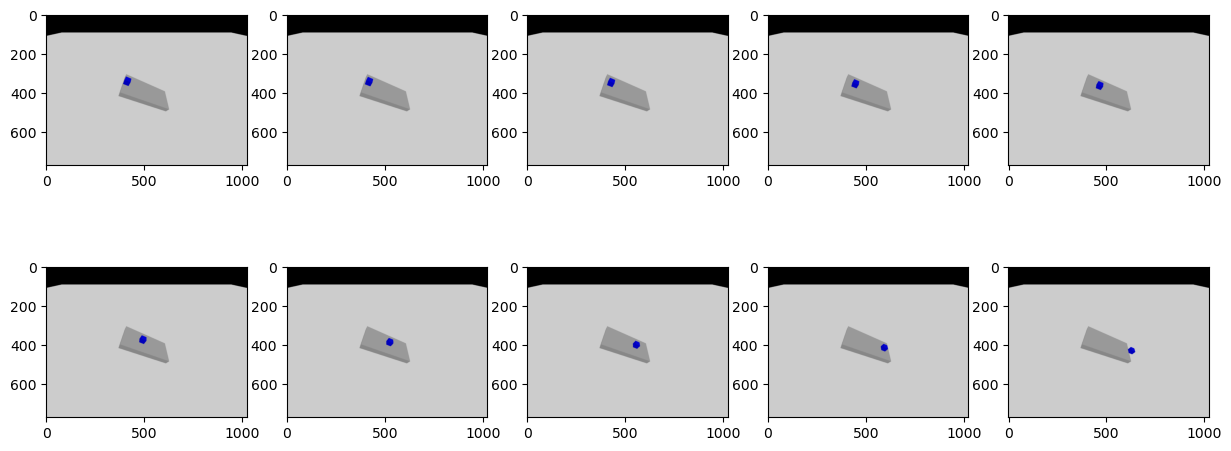

In [29]:
%matplotlib inline
scene.set_ambient_light([0.5, 0.5, 0.5])
scene.add_directional_light([0, 1, -1], [0.5, 0.5, 0.5])

camera = scene.add_camera(name='camera', width=1024, height=768, fovy=1.57, near=0.1, far=100)
camera.set_pose(sapien.Pose([-1.04541, 0, 1.54541], [0.92388, 0, 0.382683, 0]))

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))

for steps in range(100):
    scene.step()

    if steps % 10 == 0:
        # Visualization
        scene.update_render()
        camera.take_picture()
        rgba = camera.get_color_rgba()
        plt.subplot(2, 5, steps//10+1)
        plt.imshow(rgba[..., :3])

        # Get kinematic quantities
        print('step:', steps)
        print('Pose', actor.get_pose())
        print('Velocity', actor.get_velocity())
        print('Angular velocity', actor.get_angular_velocity())
plt.show()

You can restart the runtime, adjust the hyperparameters (at the beginning of the notebook) and rerun the above cells to see how changing physical properties will affect the motion of the object.

> Note: If you are working locally, you can use SAPIEN's `Viewer` to see the complete animation of the motion. For more information please refer to the comprehensive tutorial linked at the top.